In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar
import json,pickle
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter

sys.path.insert(1, '/work/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/tools/')
import derive_var
import read_and_proc
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

#### Functions

In [2]:
#Function####################################################
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
def TC_propogatespd(indexlist=None,wrfgridsize=3000,timedelta=60*60):
    uspd,vspd = [],[]
    uspd.append((indexlist[1][1]-indexlist[0][1])*wrfgridsize/(timedelta))
    vspd.append((indexlist[1][0]-indexlist[0][0])*wrfgridsize/(timedelta))
    
    for i in range(len(indexlist)-1):
        uspd.append((indexlist[i+1][1]-indexlist[i][1])*wrfgridsize/(timedelta))
        vspd.append((indexlist[i+1][0]-indexlist[i][0])*wrfgridsize/(timedelta))
    return uspd,vspd
def forward_diff(arrayin=None,delta=None,axis=None):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-1):
            temp = (arrayin[i+1,:]-arrayin[i,:])/(delta)
            result.append(temp)
        return np.asarray(result)
    
def do_PCA(var=None,timezoom=None,smooth='Yes',gaussian=0.9,fromcenter='Yes',inradius=None,outradius=None,donormal='Yes',do_PCA='Yes',do_center='Yes'):
    """
    Var: Input variable (must have 4 dimensions! Time-pres-theta-radius)
    """
    if smooth=='Yes':
        from scipy.ndimage import gaussian_filter
        normal_var = []
        if donormal=='Yes':
            for presindex in range(len(var[0,:,0,0])):
                normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'Yes'),sigma=gaussian))
        elif donormal=='No':
            if do_center=='Yes':
                for presindex in range(len(var[0,:,0,0])):
                    normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No','Yes'),sigma=gaussian))
            elif do_center=='No':
                for presindex in range(len(var[0,:,0,0])):
                    normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No','No'),sigma=gaussian))  
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    else:
        normal_var = []
        for presindex in range(len(var[0,:,0,0])):
            normal_var.append(normalize_inner(var[:,presindex,:,:],outradius))
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    if fromcenter=='Yes':
        normal_varf = np.asarray([normal_var[i,:,:,:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])
    elif fromcenter=='No':
        normal_varf = np.asarray([normal_var[i,:,:,inradius:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])
    #print("--Finish preprocesing--")
    if do_PCA=='Yes':
        from sklearn.decomposition import PCA
        import time
        start_time = time.time()
        skpcaVAR = PCA()
        skpcaVAR.fit(normal_varf.copy())
        #print("--- %s seconds ---" % (time.time() - start_time))
        return skpcaVAR,normal_var,normal_varf
    else:
        return normal_var,normal_varf

def normalize_inner(var=None,outerradius=None,standard='Yes',docenter='No'):
    PWper_ctrl = []
    for indx in range(len(var[:,0,0])):
        if docenter=='Yes':
            temp = var[indx,:,:outerradius]-np.nanmean(var[indx,:,:outerradius],axis=(0,1))
        elif docenter=='No':
            temp = var[indx,:,:outerradius]
        if standard=='Yes':
            PWper_ctrl.append((temp-np.nanmean(temp))/np.nanstd(temp))
        elif standard=='No':
            PWper_ctrl.append((temp))
    del temp
    return np.asarray(PWper_ctrl)

#### Produce baseline dataset first

In [56]:
! cp /scratch/06040/tg853394/wrfenkf/ensemble/haiyan/tracks.png ../../proc_fig/0105/

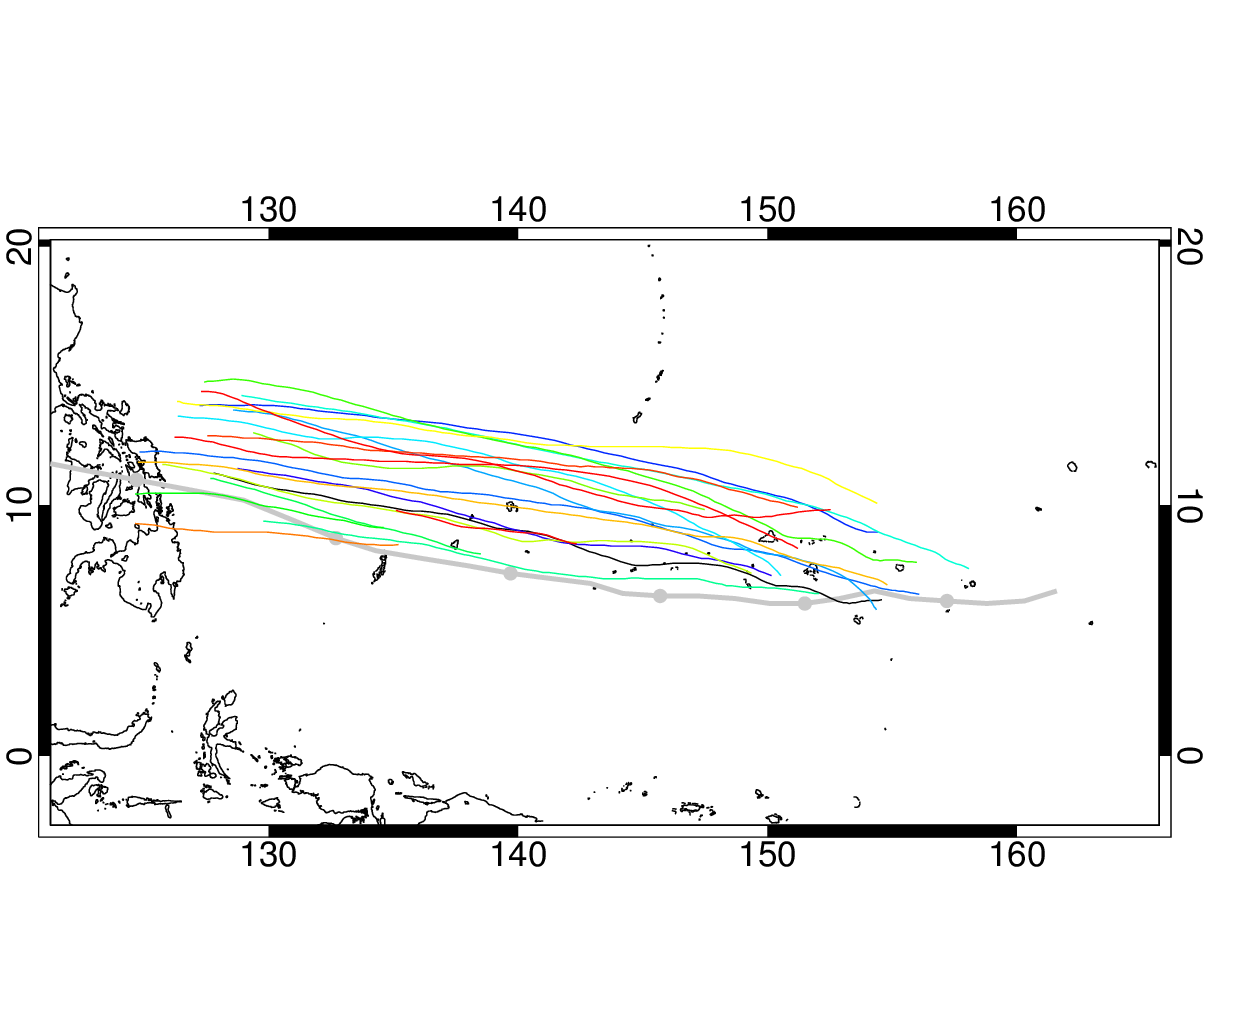

In [3]:
from IPython.core.display import Image, display
display(Image(filename='/scratch/06040/tg853394/wrfenkf/ensemble/haiyan/tracks.png'))

In [ ]:
np.swapaxes(np.asarray(read_and_proc.depickle(glob.glob(uvtpath+'theta/*0'+str(i)+'*')[0])),0,1)

In [3]:
import gc
def ingest_diurnal_savedvar(uvtpath=None,azimpath=None,savepath=None):
    for i in tqdm(range(10,21)):
        if i<10:
            ###############################################################################################
            # urad,vtan,theta & swapaxes
            ###############################################################################################
            urad = np.swapaxes(np.asarray(read_and_proc.depickle(glob.glob(uvtpath+'urad/*0'+str(i)+'*')[0])),0,1)
            vtan = np.swapaxes(np.asarray(read_and_proc.depickle(glob.glob(uvtpath+'vtan/*0'+str(i)+'*')[0])),0,1)
            theta = np.swapaxes(np.asarray(read_and_proc.depickle(glob.glob(uvtpath+'theta/*0'+str(i)+'*')[0])),0,1)
            ###############################################################################################
            # w,qv
            ###############################################################################################
            ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[azimpath+'memb_0'+str(int(i))+'/output/azim_W_0-168hr_track1.nc',\
                                                                           azimpath+'memb_0'+str(int(i))+'/output/azim_QVAPOR_0-168hr_track1.nc'],
                                        fieldname=['W','QVAPOR'])
            #ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['W']['W'].time/24,0.5)-1,nearest_index(ctrlvar_dict['W']['W'].time/24,7)-1
            r500=nearest_index(ctrlvar_dict['W']['W'].radius,500)
            ###############################################################################################
            # dtheta
            ###############################################################################################
            dtheta = forward_diff(gaussian_filter(theta,sigma=[3,0,0,0]),60*60,0)
            del theta
            gc.collect()
            ###############################################################################################
            # smooth
            ############################################################################################### 
            urads,vtans = gaussian_filter(urad,sigma=[3,0,0,0]),gaussian_filter(vtan,sigma=[3,0,0,0])
            ws,qvs = gaussian_filter(ctrlvar_dict['W']['W'],sigma=[3,0,0,0]),gaussian_filter(ctrlvar_dict['QVAPOR']['QVAPOR'],sigma=[3,0,0,0])            
            del urad,vtan,ctrlvar_dict
            gc.collect()
            #print('memb_0'+str(i))
        else:
            # urad,vtan,theta + swapaxes
            urad = np.swapaxes(np.asarray(read_and_proc.depickle(glob.glob(uvtpath+'urad/*'+str(i)+'*')[0])),0,1)
            vtan = np.swapaxes(np.asarray(read_and_proc.depickle(glob.glob(uvtpath+'vtan/*'+str(i)+'*')[0])),0,1)
            theta = np.swapaxes(np.asarray(read_and_proc.depickle(glob.glob(uvtpath+'theta/*'+str(i)+'*')[0])),0,1)
            # w,qv
            ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[azimpath+'memb_'+str(int(i))+'/output/azim_W_0-168hr_track1.nc',\
                                                                           azimpath+'memb_'+str(int(i))+'/output/azim_QVAPOR_0-168hr_track1.nc'],
                                        fieldname=['W','QVAPOR'])
            #ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['W']['W'].time/24,0.5)-1,nearest_index(ctrlvar_dict['W']['W'].time/24,7)-1
            r500=nearest_index(ctrlvar_dict['W']['W'].radius,500)
            # dtheta
            dtheta = forward_diff(gaussian_filter(theta,sigma=[3,0,0,0]),60*60,0)
            del theta
            gc.collect()
            # Smooth
            urads,vtans = gaussian_filter(urad,sigma=[3,0,0,0]),gaussian_filter(vtan,sigma=[3,0,0,0])
            ws,qvs = gaussian_filter(ctrlvar_dict['W']['W'],sigma=[3,0,0,0]),gaussian_filter(ctrlvar_dict['QVAPOR']['QVAPOR'],sigma=[3,0,0,0])            
            del urad,vtan,ctrlvar_dict
            gc.collect()
            
        urads = np.nan_to_num(urads)
        vtans = np.nan_to_num(vtans)
        ws = np.nan_to_num(ws)
        qvs = np.nan_to_num(qvs)
        dtheta = np.nan_to_num(dtheta)
        ###################################################################
        # Do PCA
        CTRL_PCAdict,CTRL_flatvardict,CTRL_origvardict = {},{},{}
        varname = ['U','V','W','QV','dthdt']
        for indx,obj in (enumerate([urads,vtans,ws,qvs,dtheta])):
            temp1,temp3,temp2 = do_PCA(var=obj,timezoom=[0,-1],smooth='Yes',
                                   gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',do_PCA='Yes',do_center='No')
            CTRL_PCAdict[varname[indx]] = temp1
            CTRL_flatvardict[varname[indx]] = temp2
            CTRL_origvardict[varname[indx]] = temp3
            del temp1,temp2,temp3
            gc.collect()
        del urads,vtans,ws,qvs,dtheta
        gc.collect()
        ####################################################################
        # Save
        if i<10:
            read_and_proc.save_to_pickle(savepath+'pca/memb_0'+str(int(i))+'_pca',CTRL_PCAdict)
            read_and_proc.save_to_pickle(savepath+'origvar/memb_0'+str(int(i))+'_origvar',CTRL_origvardict)
            read_and_proc.save_to_pickle(savepath+'flatvar/memb_0'+str(int(i))+'_flatvar',CTRL_flatvardict)
        else:
            read_and_proc.save_to_pickle(savepath+'pca/memb_'+str(int(i))+'_pca',CTRL_PCAdict)
            read_and_proc.save_to_pickle(savepath+'origvar/memb_'+str(int(i))+'_origvar',CTRL_origvardict)
            read_and_proc.save_to_pickle(savepath+'flatvar/memb_'+str(int(i))+'_flatvar',CTRL_flatvardict)            
    return None    

In [4]:
ingest_diurnal_savedvar(uvtpath='/scratch/08350/tg876493/ensemble_theta/haiyan/',azimpath='/scratch/06040/tg853394/wrfenkf/ensemble/haiyan/',\
                        savepath='/scratch/08350/tg876493/ensemble_theta/haiyan/processed/')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [33:42<00:00, 183.91s/it]


#### Figuring out the ensemble members

In [13]:
def ruppert_vtmax_calc(datadict=None,outer_limit=None):
    d2r = np.pi/180
    try:
        wdir = (np.arctan(datadict['V'].V10/datadict['U'].U10)/d2r).values
    except:
        print('Cannot find wind field arrays!')
    loc_neg = (datadict['U'].U10<0)
    wdir[loc_neg] += 180
    wspd = np.sqrt(datadict['U'].U10**2+datadict['V'].V10**2).values
    az = datadict['U'].azmiuth.values
    azt = np.moveaxis(np.tile(az,(datadict['U'].U10.shape[0],1,433,1)),-1,-2)
    Urad = wspd*np.cos((wdir-azt)*d2r)
    Vtan = wspd*np.sin((wdir-azt)*d2r)
    Vtan_max = np.max(np.mean(Vtan[:,0,:,:outer_limit],axis=1),axis=1)
    return Urad,Vtan,Vtan_max

In [14]:
azimpath='/scratch/06040/tg853394/wrfenkf/ensemble/haiyan/'
ctrlvar_dict = []
for i in tqdm(range(1,21)):
    if i<10:
        temp = read_and_proc.read_some_azimuth_fields(fileloc=[azimpath+'memb_0'+str(int(i))+'/output/azim_W_0-168hr_track1.nc'],fieldname=['W'])
        ctrlvar_dict.append(temp)
    else:
        temp = read_and_proc.read_some_azimuth_fields(fileloc=[azimpath+'memb_'+str(int(i))+'/output/azim_W_0-168hr_track1.nc'],fieldname=['W'])
        ctrlvar_dict.append(temp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 26.37it/s]


In [15]:
r500=nearest_index(ctrlvar_dict[0]['W']['W'].radius,500)
timeaxis = [obj['W']['W'].time/24 for obj in ctrlvar_dict]
del ctrlvar_dict
gc.collect()

Vtanmax_dict = []
for i in tqdm(range(1,21)):
    if i<10:
        temp = read_and_proc.read_some_azimuth_fields(fileloc=[azimpath+'memb_0'+str(int(i))+'/output/azim_U10_0-168hr_track1.nc',\
                                                              azimpath+'memb_0'+str(int(i))+'/output/azim_V10_0-168hr_track1.nc'],fieldname=['U','V'])
        _,_,Vtanmax = ruppert_vtmax_calc(datadict=temp,outer_limit=r500)
        Vtanmax_dict.append(Vtanmax)
    else:
        temp = read_and_proc.read_some_azimuth_fields(fileloc=[azimpath+'memb_'+str(int(i))+'/output/azim_U10_0-168hr_track1.nc',\
                                                              azimpath+'memb_'+str(int(i))+'/output/azim_V10_0-168hr_track1.nc'],fieldname=['U','V'])
        _,_,Vtanmax = ruppert_vtmax_calc(datadict=temp,outer_limit=r500)
        Vtanmax_dict.append(Vtanmax)       

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 19/20 [00:40<00:02,  2.12s/it]/tmp/ipykernel_204714/136373667.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  wdir[loc_neg] += 180
 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 19/20 [00:41<00:02,  2.20s/it]


IndexError: too many indices for array

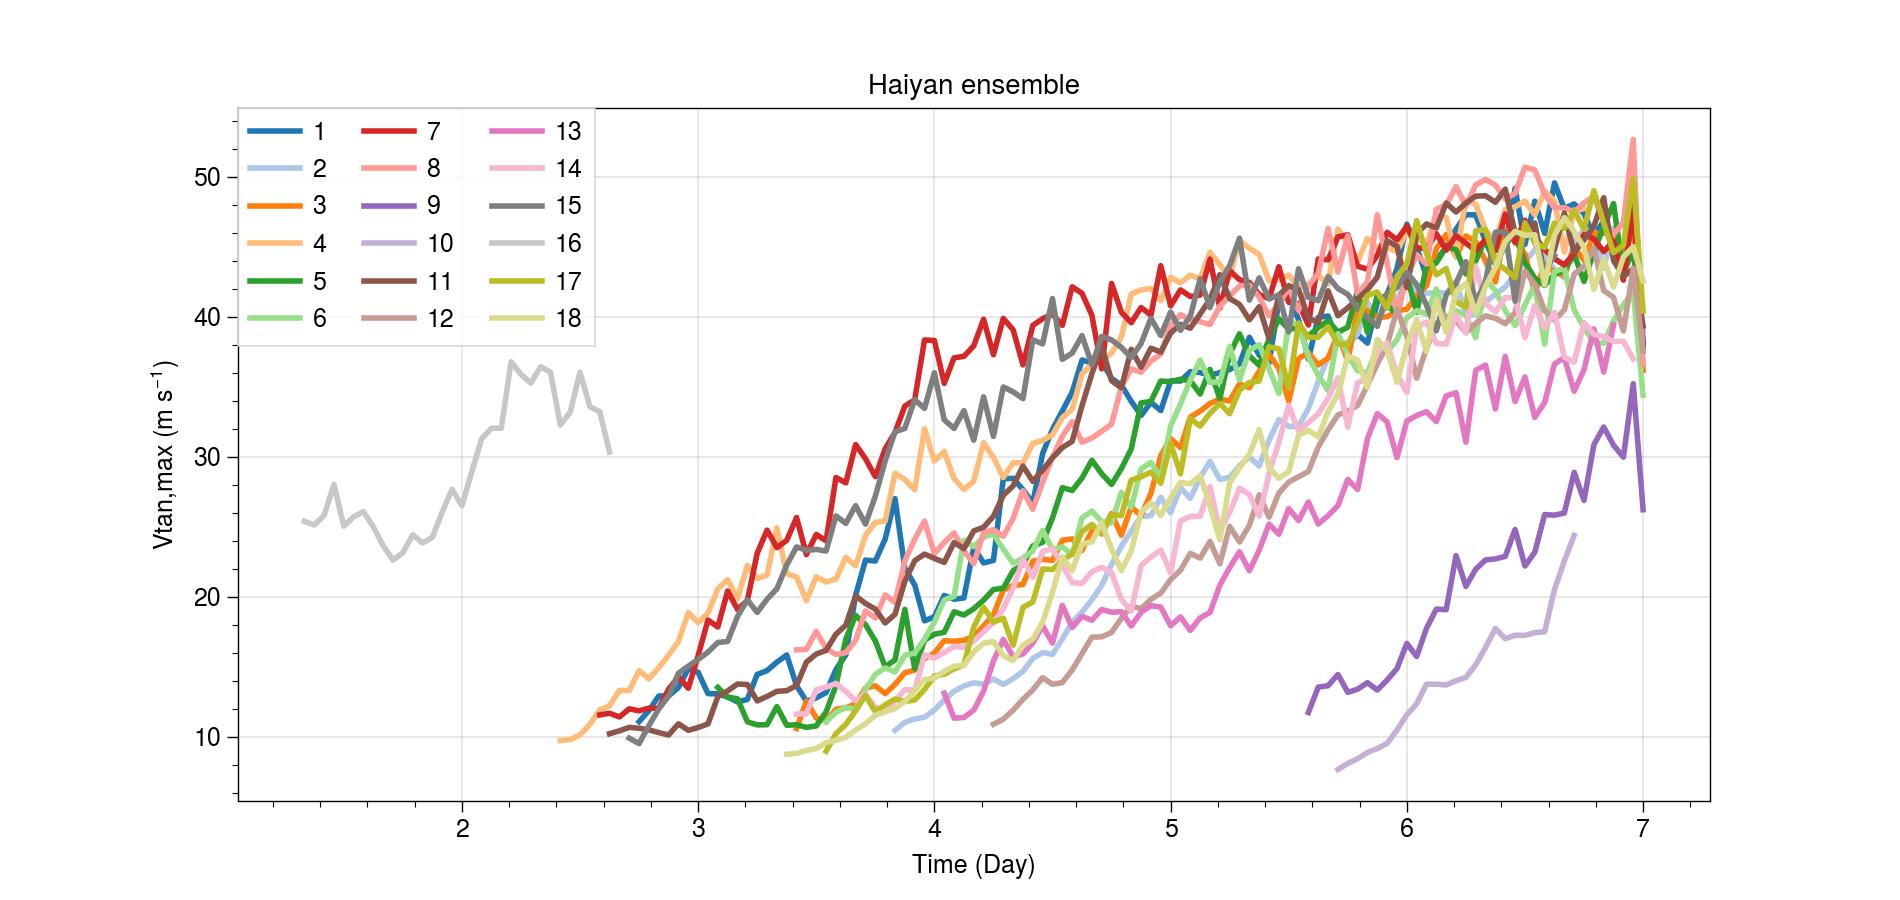

In [55]:
import matplotlib.colors as colors
import matplotlib.cm as mplcm

colors = sns.color_palette("tab20",19)[0:18]
#colors = [plt.cm.jet(i) for i in np.linspace(0, 1, 19)]
fig = plt.figure(figsize=(9.5,4.5))
ax = fig.add_subplot(111)
for i in range(18):
    lines = plt.plot(timeaxis[i],Vtanmax_dict[i],lw=2,c=colors[i],label=int(i)+1)
    ax.legend(loc=2,ncol=3)
ax.set_xlabel('Time (Day)')
ax.set_ylabel('Vtan,max (m s$^{-1}$)')
ax.set_title('Haiyan ensemble')
#ax.set_aspect(0.05)
plt.savefig('../../proc_fig/0105/ensemble_haiyan.png',dpi=400)
plt.show()

### Old codes

In [ ]:
import gc
##############################################################################################################
# Radial and Tangential Velocities
##############################################################################################################
#ctrlUrad,ctrlVtan,_ = derive_var.ruppert_vtmax_calc(ctrlvar_dict['U']['U'][28:]-np.asarray(uprop)[:,np.newaxis,np.newaxis,np.newaxis],
#                                                    ctrlvar_dict['V']['V'][28:]-np.asarray(vprop)[:,np.newaxis,np.newaxis,np.newaxis],r500)
#LWCRFUrad,LWCRFVtan,_ = derive_var.ruppert_vtmax_calc(LWCRF_u[28:]-np.asarray(uprop36)[:,np.newaxis,np.newaxis,np.newaxis],
#                                                    LWCRF_v[28:]-np.asarray(vprop36)[:,np.newaxis,np.newaxis,np.newaxis],r500,ctrlvar_dict['U']['U'][:,0,:,:].azmiuth.values,'NCRF36')
ctrlhUrad,ctrlhVtan,_ = derive_var.ruppert_vtmax_calc(ctrlvar_dict['U']['U'].data,ctrlvar_dict['V']['V'].data,r500,ctrlvar_dict['U']['U'][:,0,:,:].azmiuth.values,'NCRF36')
ncrf_36hUrad,ncrf_36hVtan,_ = derive_var.ruppert_vtmax_calc(NCRF36_u,NCRF36_v,r500,ctrlvar_dict['U']['U'][:,0,:,:].azmiuth.values,'NCRF36')
#ncrf_60hUrad,ncrf_60hVtan,_ = derive_var.ruppert_vtmax_calc(NCRF60_u[28:]-np.asarray(uprop60)[:,np.newaxis,np.newaxis,np.newaxis],
#                                                    NCRF60_v[28:]-np.asarray(vprop60)[:,np.newaxis,np.newaxis,np.newaxis],r500,ctrlvar_dict['U']['U'][:,0,:,:].azmiuth.values,'NCRF60')
ncrf_60hUrad,ncrf_60hVtan,_ = derive_var.ruppert_vtmax_calc(NCRF60_u[:],NCRF60_v[:],r500,ctrlvar_dict['U']['U'][:,0,:,:].azmiuth.values,'NCRF60')

ctrl_IR = ctrlvar_dict['RTHRATLW']['RTHRATLW']#-ctrlvar_dict['RTHRATLWC']['RTHRATLWC']
ncrf36_IR = NCRF36_RTHRATLW#-NCRF36_RTHRATLWC
ncrf60_IR = NCRF60_RTHRATLW#-NCRF60_RTHRATLWC

del NCRF36_u,NCRF60_u,NCRF36_v,NCRF60_v,ctrlvar_dict['U'],ctrlvar_dict['V'],ncrf36var_dict['U'],ncrf36var_dict['V'],ncrf60var_dict['U'],ncrf60var_dict['V']
del NCRF36_RTHRATLW,NCRF36_RTHRATLWC,NCRF60_RTHRATLW,NCRF60_RTHRATLWC
gc.collect()

In [6]:
path = '/work2/08350/tg876493/stampede2/python_codes/tcg_radiation/output/'
file = [path+'ctrl_thetaall',path+'ncrf36_thetaall',path+'ncrf60_thetaall',path+'lwcrf_thetaall']
output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
theta_dict = {'CTRL_theta':output[0],'NCRF36_theta':output[1],'NCRF60_theta':output[2],'LWCRF_theta':output[3]}
#ctrl_buoyA = 9.81*np.log(ctrl_thetaA/273.16)
# To be consistent with azimuthal files
########################################################################################################
ctrl_thetaA,ncrf36_thetaA,ncrf60_thetaA,lwcrf_thetaA = np.swapaxes(np.asarray(theta_dict['CTRL_theta']),0,1),\
np.swapaxes(np.asarray(theta_dict['NCRF36_theta']),0,1),np.swapaxes(np.asarray(theta_dict['NCRF60_theta']),0,1),\
np.swapaxes(np.asarray(theta_dict['LWCRF_theta']),0,1)

ncrf36_thetaA_todo = read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,ncrf36_thetaA,'NCRF36','Yes')
lwcrf_thetaA_todo = read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,lwcrf_thetaA,'NCRF36','Yes')
ncrf60_thetaA_todo = read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,ncrf60_thetaA,'NCRF60','Yes')
del ncrf36_thetaA,ncrf60_thetaA,lwcrf_thetaA
gc.collect()
###################################################################
# Heating Rate
###################################################################
buoy='No'
rad = 'Yes'
resi = 'Yes'
if buoy=='Yes':
    ctrl_thetagrad_b = forward_diff(gaussian_filter(ctrl_buoyA,sigma=[3,0,0,0]),60*60,0)
else:
    if rad=='Yes':
        if resi=='Yes':
            ctrl_thetagrad_b = forward_diff(gaussian_filter(ctrl_thetaA,sigma=[3,0,0,0]),60*60,0)-gaussian_filter(ctrl_rad,sigma=[3,0,0,0])[1:,:]
            ncrf36_thetagrad_b = forward_diff(gaussian_filter(ncrf36_thetaA_todo,sigma=[3,0,0,0]),60*60,0)-gaussian_filter(ncrf36_rad,sigma=[3,0,0,0])[1:,:]
            lwcrf_thetagrad_b = forward_diff(gaussian_filter(lwcrf_thetaA_todo,sigma=[3,0,0,0]),60*60,0)-gaussian_filter(lwcrf_rad,sigma=[3,0,0,0])[1:,:]
            ncrf60_thetagrad_b = forward_diff(gaussian_filter(ncrf60_thetaA_todo,sigma=[3,0,0,0]),60*60,0)-gaussian_filter(ncrf60_rad,sigma=[3,0,0,0])[1:,:]
            del ctrl_thetaA,ncrf36_thetaA_todo,ncrf60_thetaA_todo,lwcrf_thetaA_todo,ctrl_rad,ncrf36_rad,ncrf60_rad,lwcrf_rad
            gc.collect()
        else:
            ctrl_thetagrad_b = (gaussian_filter(ctrl_rad,sigma=[3,0,0,0]))[1:,:]
            ncrf36_thetagrad_b = (gaussian_filter(ncrf36_rad,sigma=[3,0,0,0]))[1:,:]
            lwcrf_thetagrad_b = (gaussian_filter(lwcrf_rad,sigma=[3,0,0,0]))[1:,:]
            ncrf60_thetagrad_b = (gaussian_filter(ncrf60_rad,sigma=[3,0,0,0]))[1:,:]
    else: 
        ctrl_thetagrad_b = forward_diff(gaussian_filter(ctrl_thetaA,sigma=[3,0,0,0]),60*60,0)
        ncrf36_thetagrad_b = forward_diff(gaussian_filter(ncrf36_thetaA_todo,sigma=[3,0,0,0]),60*60,0)
        ncrf60_thetagrad_b = forward_diff(gaussian_filter(ncrf60_thetaA_todo,sigma=[3,0,0,0]),60*60,0)
        lwcrf_thetagrad_b = forward_diff(gaussian_filter(lwcrf_thetaA_todo,sigma=[3,0,0,0]),60*60,0)
        del ctrl_thetaA,ncrf36_thetaA_todo,ncrf60_thetaA_todo,theta_dict
        gc.collect()

In [3]:
import gc
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'

#############################################################
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_RTHRATLW_0-144hr.nc',origin_path+'ctl/azim_RTHRATSW_0-144hr.nc',origin_path+'ctl/azim_RTHRATLWC_0-144hr.nc',origin_path+'ctl/azim_RTHRATSWC_0-144hr.nc'],
                                        fieldname=['RTHRATLW','RTHRATSW','RTHRATLWC','RTHRATSWC'])
ncrf60var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_60h/azim_RTHRATLW_60-144hr.nc',origin_path+'ncrf_60h/azim_RTHRATSW_60-144hr.nc',origin_path+'ncrf_60h/azim_RTHRATLWC_60-144hr.nc',origin_path+'ncrf_60h/azim_RTHRATSWC_60-144hr.nc'],
                                          fieldname=['RTHRATLW','RTHRATSW','RTHRATLWC','RTHRATSWC'])
lwcrfvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'lwcrf/azim_RTHRATLW_36-144hr.nc',origin_path+'lwcrf/azim_RTHRATSW_36-144hr.nc',origin_path+'lwcrf/azim_RTHRATLWC_36-144hr.nc',origin_path+'lwcrf/azim_RTHRATSWC_36-144hr.nc'],
                                          fieldname=['RTHRATLW','RTHRATSW','RTHRATLWC','RTHRATSWC'])
ncrf36var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_36h/azim_RTHRATLW_36-144hr.nc',origin_path+'ncrf_36h/azim_RTHRATSW_36-144hr.nc',origin_path+'ncrf_36h/azim_RTHRATLWC_36-144hr.nc',origin_path+'ncrf_36h/azim_RTHRATSWC_36-144hr.nc'],
                                          fieldname=['RTHRATLW','RTHRATSW','RTHRATLWC','RTHRATSWC'])
r300,r500=(nearest_index(ctrlvar_dict['RTHRATLW']['RTHRATLW'].radius,300),nearest_index(ctrlvar_dict['RTHRATLW']['RTHRATLW'].radius,500))
NCRF36_LW,NCRF36_SW,NCRF36_LWC,NCRF36_SWC = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATLW']['RTHRATLW'],ncrf36var_dict['RTHRATLW']['RTHRATLW'],'NCRF36','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATSW']['RTHRATSW'],ncrf36var_dict['RTHRATSW']['RTHRATSW'],'NCRF36','Yes'),read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATLWC']['RTHRATLWC'],ncrf36var_dict['RTHRATLWC']['RTHRATLWC'],'NCRF36','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATSWC']['RTHRATSWC'],ncrf36var_dict['RTHRATSWC']['RTHRATSWC'],'NCRF36','Yes')
LWCRF_LW,LWCRF_SW,LWCRF_LWC,LWCRF_SWC = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATLW']['RTHRATLW'],lwcrfvar_dict['RTHRATLW']['RTHRATLW'],'NCRF36','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATSW']['RTHRATSW'],lwcrfvar_dict['RTHRATSW']['RTHRATSW'],'NCRF36','Yes'),read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATLWC']['RTHRATLWC'],lwcrfvar_dict['RTHRATLWC']['RTHRATLWC'],'NCRF36','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATSWC']['RTHRATSWC'],lwcrfvar_dict['RTHRATSWC']['RTHRATSWC'],'NCRF36','Yes')
NCRF60_LW,NCRF60_SW,NCRF60_LWC,NCRF60_SWC = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATLW']['RTHRATLW'],ncrf60var_dict['RTHRATLW']['RTHRATLW'],'NCRF60','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATSW']['RTHRATSW'],ncrf60var_dict['RTHRATSW']['RTHRATSW'],'NCRF60','Yes'),read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATLWC']['RTHRATLWC'],ncrf60var_dict['RTHRATLWC']['RTHRATLWC'],'NCRF60','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['RTHRATSWC']['RTHRATSWC'],ncrf60var_dict['RTHRATSWC']['RTHRATSWC'],'NCRF60','Yes')

In [4]:
radtype = 'all'
if radtype=='all':
    ctrl_rad = ctrlvar_dict['RTHRATLW']['RTHRATLW']+ctrlvar_dict['RTHRATSW']['RTHRATSW']
    ncrf36_rad = NCRF36_LW+NCRF36_SW
    lwcrf_rad = LWCRF_LW+LWCRF_SW
    ncrf60_rad = NCRF60_LW+NCRF60_SW
elif radtype=='ir':
    ctrl_rad = ctrlvar_dict['RTHRATLW']['RTHRATLW']-ctrlvar_dict['RTHRATLWC']['RTHRATLWC']
    ncrf36_rad = NCRF36_LW-NCRF36_LWC
    lwcrf_rad = LWCRF_LW-LWCRF_LWC
    ncrf60_rad = NCRF60_LW-NCRF60_LWC    
del ncrf60var_dict,ncrf36var_dict,lwcrfvar_dict,LWCRF_LW,LWCRF_SW,LWCRF_LWC,LWCRF_SWC,NCRF36_LW,NCRF36_SW,NCRF36_LWC,NCRF36_SWC,NCRF60_LW,NCRF60_SW,NCRF60_LWC,NCRF60_SWC
gc.collect()

175

#### Potential Temperature

In [10]:
def save_singledict(inarray=[ctrl_thetagrad_b,ncrf36_thetagrad_b,ncrf60_thetagrad_b,lwcrf_thetagrad_b],varname=['ctrlHEAT','ncrf36HEAT','ncrf60HEAT','lwcrfHEAT'],\
                    saveloc='../output/1010_nc/simple/HEAT_flatvardict',timezoom=None,outradius=None,gaussian=[0,0,0]):
    DTHDTdict = {}
    dictname = ['ctrldthdt','ncrf36dthdt','ncrf60dthdt','lwcrfdthdt']
    for indx,obj in tqdm(enumerate(inarray)):
        #DTHDTdict[dictname[indx]] = uniform_filter1d((obj),size=24,axis=0)
        DTHDTdict[dictname[indx]] = obj
        
    CTRL_flatvardict = {}
    for indx,obj in tqdm(enumerate([DTHDTdict['ctrldthdt'],DTHDTdict['ncrf36dthdt'],DTHDTdict['ncrf36dthdt'],DTHDTdict['lwcrfdthdt']])):
        _,temp2 = do_PCA(var=obj,timezoom=timezoom,smooth='Yes',
                         gaussian=gaussian,fromcenter='Yes',inradius=None,outradius=outradius,donormal='No',do_PCA='No',do_center='No')
        CTRL_flatvardict[varname[indx]] = temp2
        del temp2
        gc.collect()
    del DTHDTdict
    gc.collect()
    read_and_proc.save_to_pickle(loc=saveloc,var=CTRL_flatvardict)
    return None

In [11]:
###################################################################
# Cut off time
###################################################################
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_U_0-144hr.nc'],fieldname=['U'])
ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['U']['U'].time/24,1)-1,nearest_index(ctrlvar_dict['U']['U'].time/24,5)-1
r300,r500=nearest_index(ctrlvar_dict['U']['U'].radius,300),nearest_index(ctrlvar_dict['U']['U'].radius,500)

save_singledict(inarray=[ctrl_thetagrad_b,ncrf36_thetagrad_b,ncrf60_thetagrad_b,lwcrf_thetagrad_b],varname=['ctrlRESI','ncrf36RESI','ncrf60RESI','lwcrfRESI'],\
                    saveloc='../output/1010_nc/simple/RESI_flatvardict',timezoom=[ctrl_t2,ctrl_t4],outradius=r500,gaussian=[0,0,0])

4it [00:00, 6892.86it/s]
4it [00:14,  3.73s/it]


##### Output time difference terms

#### Sanity check (2021/10/30)

In [32]:
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)

# T(T=2hr)=T(T=1hr)+dT/dt(1-2hr)*t
TEST = np.swapaxes(np.asarray(ctrlUrad),0,1)[23,6,:,:r500].copy()
TESTv = np.swapaxes(np.asarray(ctrlVtan),0,1)[23,6,:,:r500].copy()
tcount=nearest_index(ctrlvar_dict['U']['U'].time/24,1)-1
while tcount<=nearest_index(ctrlvar_dict['U']['U'].time/24,2)-1:
    #TEST+=ctrl_ugrad_b[tcount][6,:,:r500]*(2*60*60)+4*ctrlvar_dict['U']['U'][tcount-1][6,:,:r500]-ctrlvar_dict['U']['U'][tcount-2][6,:,:r500]
    TEST+=ctrl_urad_f[tcount,6,:,:r500]*(60*60)
    TESTv+=ctrl_vtan_f[tcount,6,:,:r500]*(60*60)
    tcount+=1

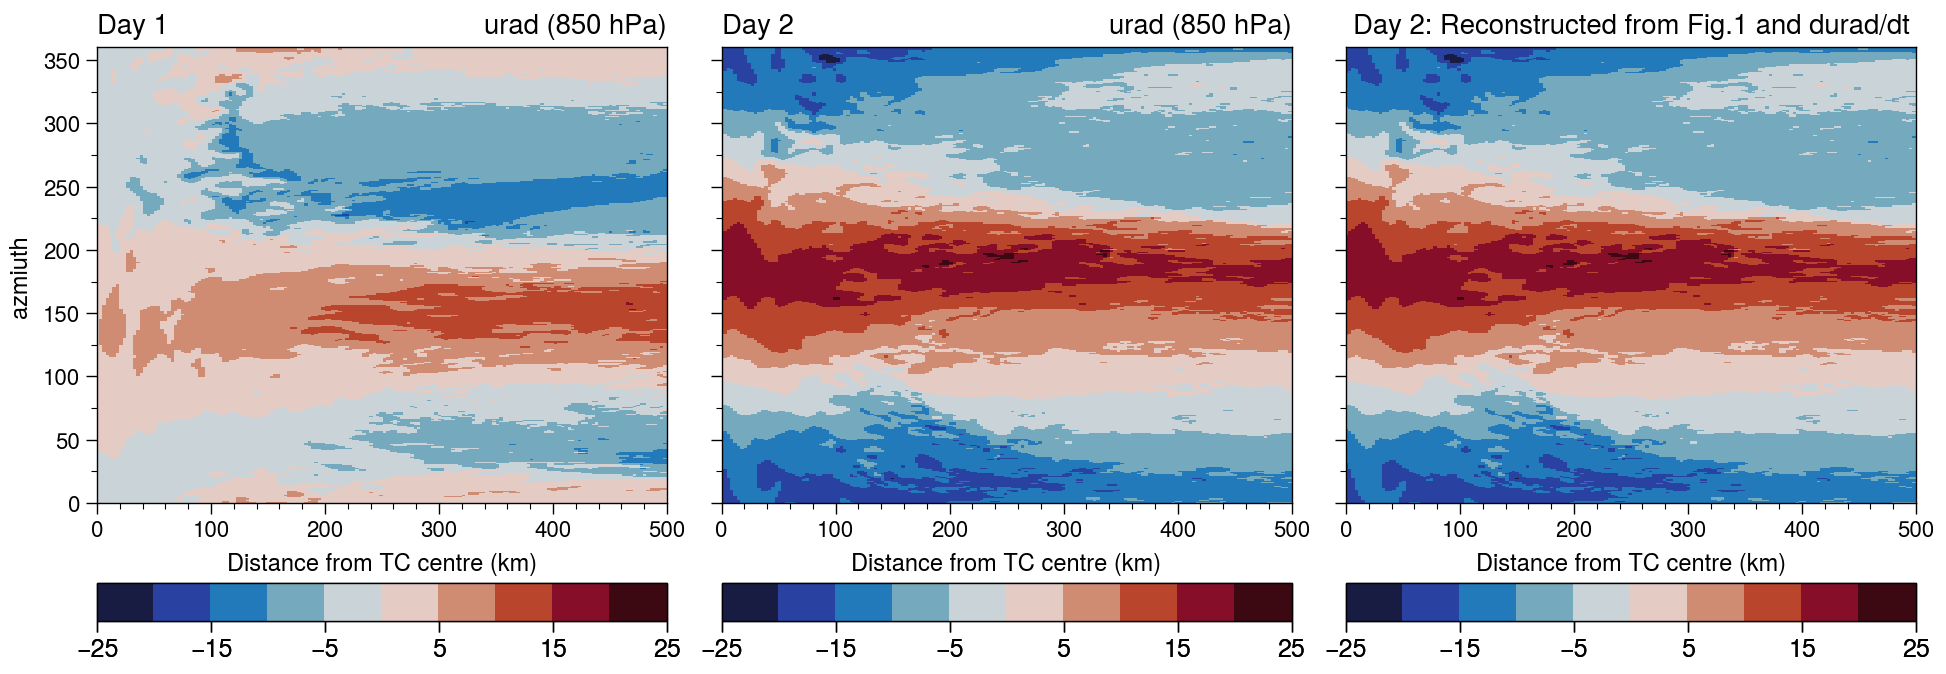

In [36]:
import matplotlib.ticker as mticker
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].pcolormesh(ctrlvar_dict['U'].radius[:r500],ctrlvar_dict['U'].azmiuth,np.swapaxes(np.asarray(ctrlUrad),0,1)[23,6,:,:r500],
                      cmap='balance',vmin=-27,vmax=27)
axs[0].colorbar(img,loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Day 1',rtitle='urad (850 hPa)')
img=axs[1].pcolormesh(ctrlvar_dict['U'].radius[:r500],ctrlvar_dict['U'].azmiuth,np.swapaxes(np.asarray(ctrlUrad),0,1)[23+25,6,:,:r500],
                      cmap='balance',vmin=-27,vmax=27)
axs[1].colorbar(img,loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Day 2',rtitle='urad (850 hPa)')
img=axs[2].pcolormesh(ctrlvar_dict['U'].radius[:r500],ctrlvar_dict['U'].azmiuth,TEST,
                      cmap='balance')
axs[2].colorbar(img,loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='Day 2: Reconstructed from Fig.1 and durad/dt')
#img=axs[3].pcolormesh(ctrlvar_dict['U'].radius[:r500],ctrlvar_dict['U'].azmiuth,TEST-np.swapaxes(np.asarray(ctrlUrad),0,1)[23+25,6,:,:r500],
#                      cmap='balance')
#axs[3].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='Residual')
#axs.format(yticks=[18.22,108.22,198.22,288.22],yticklabels=['DL','DR','UR','UL'],leftlabels='Maria',ylabel='')
for axisobj in axs:
    axisobj.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
    
plt.show()

PCA

In [7]:
###################################################################
# Cut off time
###################################################################
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_U_0-144hr.nc'],fieldname=['U'])
ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['U']['U'].time/24,1)-1,nearest_index(ctrlvar_dict['U']['U'].time/24,5)-1
r300,r500=nearest_index(ctrlvar_dict['U']['U'].radius,300),nearest_index(ctrlvar_dict['U']['U'].radius,500)
###################################################################
# Time difference: gaussian=[0,0,0]; Other: gaussian=[3,0,0]
###################################################################
####################################################################
# Output radiative terms/WG terms
CTRL_flatvardict = {}
varname = ['ctrlHEAT','ncrf36HEAT','ncrf60HEAT','lwcrfHEAT']
for indx,obj in tqdm(enumerate([DTHDTdict['ctrldthdt'],DTHDTdict['ncrf36dthdt'],DTHDTdict['ncrf36dthdt'],DTHDTdict['lwcrfdthdt']])):
    _,temp2 = do_PCA(var=obj,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                           gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',do_PCA='No',do_center='No')
    CTRL_flatvardict[varname[indx]] = temp2
    del temp2
    gc.collect()
del DTHDTdict
gc.collect()

4it [00:14,  3.65s/it]


0

##### Save

In [8]:
import json,pickle
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

#!mkdir outputCTRL_PCAdict,CTRL_flatvardict
#save_to_pickle(loc='../output/1010_nc_nodiurnal/CTRL_PCAdict',var=CTRL_PCAdict)
save_to_pickle(loc='../output/1010_nc/simple/HEAT_flatvardict',var=CTRL_flatvardict)
#save_to_pickle(loc='../output/1010_nc_nodiurnal/LWCRF_flatvardict',var=NCRF36_flatvardict)
#save_to_pickle(loc='../output/1010_nc_nodiurnal/NCRF60_flatvardict',var=NCRF60_flatvardict)

In [9]:
import json,pickle
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

#!mkdir output
# PCA
#save_to_pickle(loc='./output/1010_nc/QV_pca_nc',var=skpcaQV_test)
#save_to_pickle(loc='./output/1010_nc/U_pca_nc',var=skpcaU_test)
#save_to_pickle(loc='./output/1010_nc/V_pca_nc',var=skpcaV_test)
#save_to_pickle(loc='./output/1010_nc/W_pca_nc',var=skpcaW_test)
#save_to_pickle(loc='../output/1010_nc/BUOY_pca_nc',var=skpcaBUOY_test)

# Normalized data
#save_to_pickle(loc='./output/1010_nc/normalQV_ctrl_nc',var=normalQVctrl)
#save_to_pickle(loc='./output/1010_nc/normalU_ctrl_nc',var=normalUctrl)
#save_to_pickle(loc='./output/1010_nc/normalV_ctrl_nc',var=normalVctrl)
#save_to_pickle(loc='./output/1010_nc/normalWG_ctrl_nc',var=normalWGfctrl)
#save_to_pickle(loc='../output/1010_nc/normalBUOY_ctrl_nc',var=normalBUOYctrl)
#save_to_pickle(loc='./output/1010_nc/normalUradG_ctrl_nc',var=normalUradGctrl)
#save_to_pickle(loc='./output/1010_nc/normalVtanG_ctrl_nc',var=normalVtanGctrl)
#save_to_pickle(loc='./output/1010_nc/normalUradG_ncrf36_nc',var=normalUradGncrf36)
#save_to_pickle(loc='./output/1010_nc/normalVtanG_ncrf36_nc',var=normalVtanGncrf36)
#save_to_pickle(loc='./output/1010_nc/normalWG_ncrf36_nc',var=normalWGncrf36)
#save_to_pickle(loc='./output/1010_nc/normalUradG_ncrf60_nc',var=normalUradGncrf60)
#save_to_pickle(loc='./output/1010_nc/normalVtanG_ncrf60_nc',var=normalVtanGncrf60)
#save_to_pickle(loc='./output/1010_nc/normalWG_ncrf60_nc',var=normalWGncrf60)

# Normalized data Flattened
#save_to_pickle(loc='./output/1010_nc/normalQV_ctrlf_nc',var=normalQVctrlf)
save_to_pickle(loc='../output/1010_nc/radiation/normalNOLW_ctrlf_nc',var=normalRTHRATLWctrlf)
#save_to_pickle(loc='../output/1010_nc/radiation/normalIR_ctrlf_nc',var=normalIRctrlf)
#save_to_pickle(loc='./output/1010_nc/normalVtanG_ctrlf_nc',var=normalVtanGfctrl)
save_to_pickle(loc='../output/1010_nc/radiation/normalNOLW_ncrf36f_nc',var=normalRTHRATLWncrf36f)
#save_to_pickle(loc='../output/1010_nc/radiation/normalIR_ncrf36f_nc',var=normalIRncrf36f)
save_to_pickle(loc='../output/1010_nc/radiation/normalNOLW_ncrf60f_nc',var=normalRTHRATLWncrf60f)
#save_to_pickle(loc='../output/1010_nc/radiation/normalIR_ncrf60f_nc',var=normalIRncrf60f)

In [ ]:
del ctrl_thetagrad_b,ncrf36_thetagrad_b,ncrf60_thetagrad_b,lwcrf_thetagrad_b
gc.collect()